<a href="https://colab.research.google.com/github/nicoRomeroCuruchet/DynamicProgramming/blob/main/testing_bary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
from PolicyIteration import PolicyIteration
from utils.utils import plot_2D_value_function,\
                        plot_3D_value_function,\
                        test_enviroment

# CartPoleEnv 

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

In [ ]:
# Train cartpole environment:
from classic_control.cartpole import CartPoleEnv

env = CartPoleEnv(sutton_barto_reward=True)
# position thresholds:
x_lim         = 2.4
theta_lim     = 0.418 
# velocity thresholds:
x_dot_lim     = 3.1
theta_dot_lim = 3.1

bins_space = {
    "x_space"         : np.linspace(-x_lim, x_lim, 10,  dtype=np.float32),                     # position space          (0)
    "x_dot_space"     : np.linspace(-x_dot_lim, x_dot_lim, 10,  dtype=np.float32),             # velocity space          (1)
    "theta_space"     : np.linspace(-theta_lim, theta_lim, 10, dtype=np.float32),              # angle space             (2)
    "theta_dot_space" : np.linspace(-theta_dot_lim, theta_dot_lim, 10, dtype=np.float32),      # angular velocity space  (3)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.array([0, 1], dtype=np.int32),
    gamma=0.99,
    theta=1e-3
)

pi.run()

In [ ]:
# Test cartpole environment:

with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi = pickle.load(f)

test_enviroment(CartPoleEnv(sutton_barto_reward=True, render_mode="human"), pi)

## Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min   | Max  | Unit         |
|-----|--------------------------------------|-------|------|--------------|
| 0   | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1   | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

## Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don't accelerate
- 2: Accelerate to the right


In [12]:
from classic_control.continuous_mountain_car import Continuous_MountainCarEnv

env=Continuous_MountainCarEnv()

bins_space = {
    "x_space":     np.linspace(env.min_position, env.max_position, 250,      dtype=np.float32),    # position space    (0)
    "x_dot_space": np.linspace(-abs(env.max_speed), abs(env.max_speed), 250, dtype=np.float32),    # velocity space    (1)
}

pi = PolicyIteration(
    env=env, 
    bins_space=bins_space,
    action_space=np.linspace(-1.0, +1.0,9, dtype=np.float32),
    gamma=0.99,
    theta=1e-3,
)
pi.run() # 250*

2024-09-18 12:57:07.327 | INFO     | PolicyIteration:__init__:129 - Lower bounds: [-1.2  -0.07]
2024-09-18 12:57:07.328 | INFO     | PolicyIteration:__init__:130 - Upper bounds: [0.6  0.07]
2024-09-18 12:57:07.464 | INFO     | PolicyIteration:__init__:142 - The action space is: [-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
2024-09-18 12:57:07.466 | INFO     | PolicyIteration:__init__:143 - Number of states: 62500
2024-09-18 12:57:07.466 | INFO     | PolicyIteration:__init__:144 - Total states:562500
2024-09-18 12:57:07.467 | INFO     | PolicyIteration:__init__:147 - Creating Delaunay triangulation...
2024-09-18 12:57:08.280 | INFO     | PolicyIteration:__init__:149 - Delaunay triangulation created.
2024-09-18 12:57:08.338 | INFO     | PolicyIteration:__init__:171 - Policy Iteration was correctly initialized.
2024-09-18 12:57:08.339 | INFO     | PolicyIteration:__init__:172 - The enviroment name is: Continuous_MountainCarEnv
2024-09-18 12:57:08.339 | INFO     | PolicyIteration

In [23]:
import jax
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
devices = jax.local_devices()
print(devices) # >>> [GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0)]

nmp = jax.numpy.ones(4)
print(nmp.device) # >>> gpu:0

#nmp = jax.device_put(nmp, jax.devices()[1])
#print(nmp.device) # >>> gpu:1

[CpuDevice(id=0)]
TFRT_CPU_0


In [ ]:
# Test mountain car environment:
with open(env.__class__.__name__ + ".pkl", "rb") as f:
    pi: PolicyIteration = pickle.load(f)

test_enviroment(Continuous_MountainCarEnv(render_mode="human"), pi)

In [ ]:
# graph the value function of the mountain car environment:
plot_3D_value_function(pi.value_function)
plot_2D_value_function(pi.value_function)

In [ ]:
import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()
pi.calculate_transition_reward_table()
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

In [ ]:
import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()
pi.run()
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

[0.48022604 0.5466515 ]


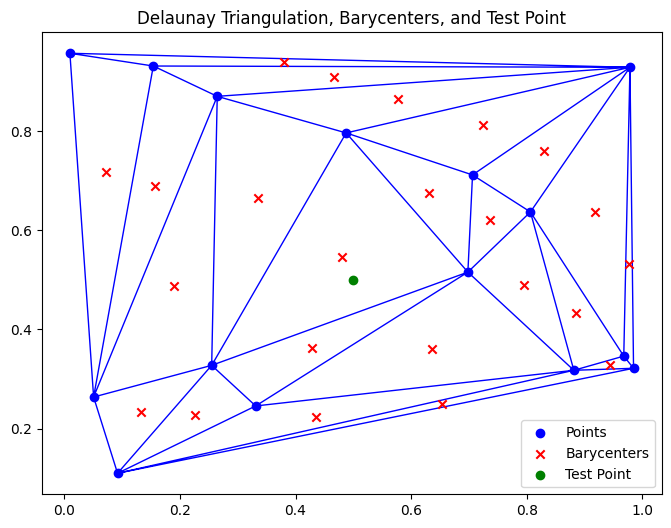

The barycenter for the triangle containing point [0.5 0.5] is [0.48022604 0.5466515 ]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Step 1: Generate a set of random points
points = np.random.rand(15, 2)  # 15 random 2D points

# Step 2: Perform Delaunay triangulation
tri = Delaunay(points)

# Step 3: Calculate barycenters (centroids) for each triangle
barycenters = []
for simplex in tri.simplices:
    vertices = points[simplex]
    # Barycenter is the average of the vertices' coordinates
    centroid = np.mean(vertices, axis=0)
    barycenters.append(centroid)

barycenters = np.array(barycenters)

# Step 4: Define a function to find the barycenter for a given point
def find_barycenter(point, triangulation, barycenters):
    simplex_index = triangulation.find_simplex(point)
    if simplex_index == -1:
        return None  # Point not inside any triangle
    return barycenters[simplex_index]

# Test with a point
test_point = np.array([0.5, 0.5])
barycenter_of_triangle = find_barycenter(test_point, tri, barycenters)
print(barycenter_of_triangle)

# Step 5: Plot the points, triangulation, and barycenters
plt.figure(figsize=(8, 6))
plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='blue', linewidth=1)
plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')
plt.scatter(barycenters[:, 0], barycenters[:, 1], color='red', marker='x', label='Barycenters')
plt.scatter(test_point[0], test_point[1], color='green', marker='o', label='Test Point')
plt.title('Delaunay Triangulation, Barycenters, and Test Point')
plt.legend()
plt.show()

# Output the found barycenter for the test point
if barycenter_of_triangle is not None:
    print(f"The barycenter for the triangle containing point {test_point} is {barycenter_of_triangle}")
else:
    print(f"The point {test_point} is outside the triangulation.")
